In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 

In [2]:
import os

charts_path = "Data/chart/continuous/"

list_chart = [i for i in os.listdir(charts_path) if i not in ['no_legend', '.DS_Store']]

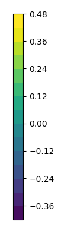

In [3]:
# There are in total 5 images for test, 9.png, 14.png, 23.png, 32.png, 33.png. 
# To have a satisfactory effect, it is essential to modify the seed point.

img_bgr = cv2.imread(charts_path+'23.png', cv2.IMREAD_COLOR) 
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [4]:
img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)

In [5]:
def find_most_frequent_color(img):
    data = np.reshape(img, (-1,3))
    dict_count = {}

    for i in range(data.shape[0]):
        if str(data[i,:].tolist()) not in dict_count.keys():
            dict_count[str(data[i,:].tolist())] = 1
        else:
            dict_count[str(data[i,:].tolist())] += 1
            
    color_str = sorted(dict_count.items(), key=lambda x:x[1], reverse=1)[0][0]
    return np.fromstring(color_str[1:-1], dtype=int, sep=',')



In [6]:
mfc = find_most_frequent_color(img_lab)

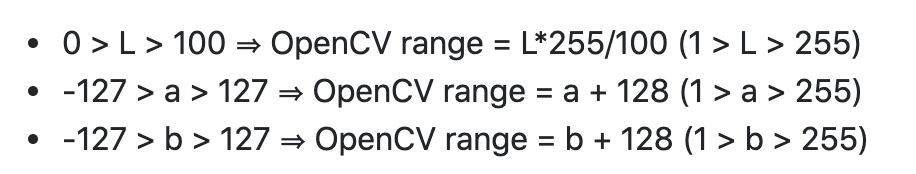

In [7]:
def mask_img(img, mfc, T_bg=5):
    
    mask = np.ones((img.shape[0], img.shape[1]), dtype='uint8')

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
        # mask for background
            if np.max(abs(img[i,j]-mfc)) <= T_bg:
                img[i,j] = [255,128,128]
                mask[i,j] = 0    
    
    return img, mask

In [8]:
masked_img_lab,mask = mask_img(img_lab, mfc, T_bg=0)

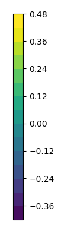

In [9]:
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

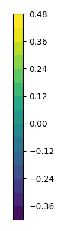

In [10]:
plt.imshow(cv2.cvtColor(masked_img_lab, cv2.COLOR_LAB2RGB))
plt.axis('off')
plt.show()

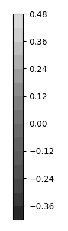

In [11]:
img_gray = cv2.cvtColor(cv2.cvtColor(masked_img_lab, cv2.COLOR_LAB2BGR), cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

In [12]:
def binarize(img):
    img_gray = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_LAB2BGR), cv2.COLOR_BGR2GRAY).reshape(-1,)
    mask_above_127 = (img_gray > 127)
    mask_below_127 = (img_gray <= 127)
    img_gray[mask_above_127] = 0
    img_gray[mask_below_127] = 1
    
    return img_gray.reshape((img.shape[0], img.shape[1]))

In [13]:
img_binary = binarize(masked_img_lab)

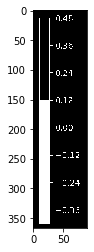

In [14]:
plt.imshow(img_binary, cmap='gray', vmin=0, vmax=1)
# plt.axis('off')
plt.show()

In [15]:
# we may not
def flood_fill(img, seed_point=(20, 100)):
    return cv2.floodFill(img_binary, None, seed_point, 1)[1]

In [16]:
img_filled = flood_fill(img_binary)

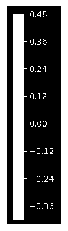

In [17]:
plt.imshow(img_filled, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

In [18]:
def erode(img, kernel_size=5, iteration=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    img_eroded = cv2.erode(img, kernel, iterations = iteration)
    return img_eroded

In [19]:
img_eroded = erode(img_filled, kernel_size=5)

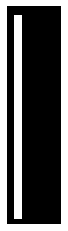

In [20]:
plt.imshow(img_eroded, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

In [21]:
num_labels, labels_im = cv2.connectedComponents(img_eroded)

In [22]:
num_labels

2

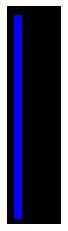

In [23]:
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_LAB2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    plt.imshow(labeled_img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()
#     cv2.waitKey()

imshow_components(labels_im)

In [24]:
def find_largest_connected_component(img):
    num_labels, labels = cv2.connectedComponents(img)
    dict_area = {}
    for i in range(num_labels):
        dict_area[i] = area_i = np.sum(labels_im == i)
                  
    return sorted(dict_area.items(), key=lambda x:x[1], reverse=1)[1][0], labels

In [25]:
idx, labels = find_largest_connected_component(img_eroded)

In [26]:
def get_colors(img, idx, labels):
    positions = np.argwhere(labels==idx)
    position_lefttop = positions[0,:]
    position_rightbottom = positions[-1,:]
    
    # width <= height
    if (position_lefttop[0]-position_rightbottom[0]) <= (position_lefttop[1]-position_rightbottom[1]):
        # most_top_color, most_bottom_color
        return [img_lab[position_lefttop[0], int((position_lefttop[1]+position_rightbottom[1])/2)], \
                img_lab[position_rightbottom[0], int((position_lefttop[1]+position_rightbottom[1])/2)]]
    else:
        return [img_lab[int((position_lefttop[0]+position_rightbottom[0])/2), position_lefttop[1]], \
                img_lab[int((position_lefttop[1]+position_rightbottom[1])/2), position_lefttop[0]]]

In [27]:
colors = get_colors(img_lab, idx, labels)

In [28]:
def plot_color(colors):
    color_matrices = []
    for i in colors:
        color_matrices.append(np.full((20, 20, 3), i.tolist(), dtype='uint8'))
        
    img = np.concatenate(color_matrices, axis=1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_LAB2RGB))
    plt.axis('off')
    plt.show()   
    
#     return img

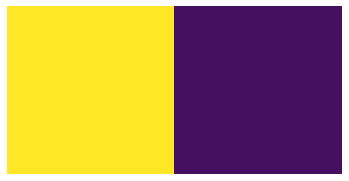

In [29]:
plot_color(colors)